# Assignment 1 - by Daniel Marcon and Aurora Pia Ghiardelli

In [1]:
import numpy as np
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

np.random.seed(42)

The goal of this project is to create a neural network with 3 layers: input - hidden - output. Both the input layer and the output layer will have 8 nodes, the hidden layer only 3 nodes(+ biases).

The learning examples will each have 7 zeros and 1 one in them(so there will be only 8 different learning examples, and you will have to repeat the,) and the ouput the network should learn is exactly the same as the input.  So when the input layer is given < 0,0,0,1,0,0,0,0 > as input, the output to aim for is also < 0,0,0,1,0,0,0,0 >.

We train the neural network using **Online Gradient Descent**.

We want our network to learn this reproducing function on the 8 different learning examples. 

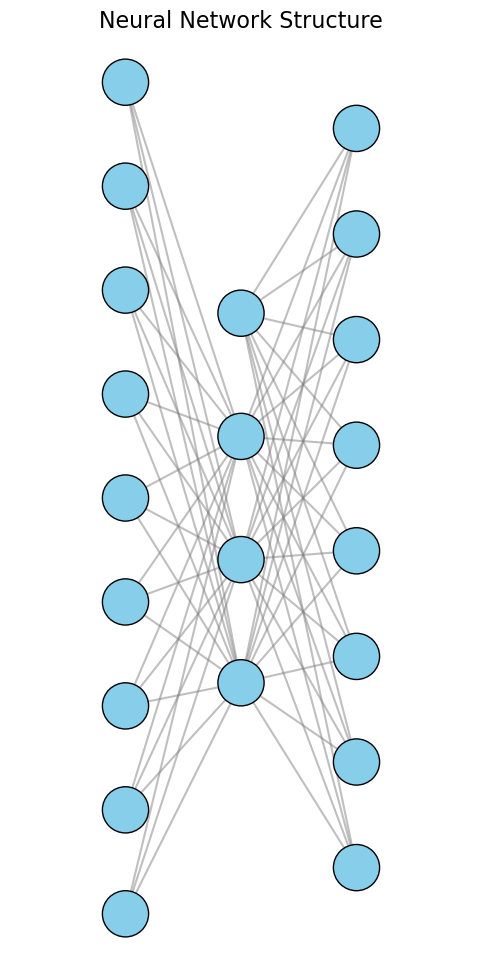

In [2]:
def plot_neural_network(layer_sizes, neuron_radius=0.5, exclude_bias_connections=True):
    x_spacing = 2.5
    y_spacing = 2.0
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.axis('off')

    x_positions = np.arange(len(layer_sizes)) * x_spacing

    for layer_idx, num_neurons in enumerate(layer_sizes):
        y_positions = np.linspace(-num_neurons * y_spacing / 2, num_neurons * y_spacing / 2, num_neurons)
        
        for y in y_positions:
            ax.add_patch(plt.Circle((x_positions[layer_idx], y), neuron_radius, color='skyblue', ec='black', zorder=2))
        
        if layer_idx < len(layer_sizes) - 1:
            next_y_positions = np.linspace(-layer_sizes[layer_idx + 1] * y_spacing / 2, layer_sizes[layer_idx + 1] * y_spacing / 2, layer_sizes[layer_idx + 1])
            
            for i, y_current in enumerate(y_positions):
                for j, y_next in enumerate(next_y_positions):
                    if exclude_bias_connections and layer_idx == 0 and j == len(next_y_positions) - 1:
                        continue
                    ax.plot([x_positions[layer_idx], x_positions[layer_idx + 1]], [y_current, y_next], 'gray', alpha=0.5, zorder=1)

    ax.set_aspect('equal')
    ax.set_xlim(-x_spacing, x_positions[-1] + x_spacing)
    ax.set_ylim(-max(layer_sizes) * y_spacing / 2 - 1, max(layer_sizes) * y_spacing / 2 + 1)
    plt.title("Neural Network Structure", fontsize=16)
    plt.show()

layer_sizes = [9,4, 8]
plot_neural_network(layer_sizes)

# Activation functions init
Here are defined some activation functions and their derivatives, currently only sigmoid are used but for testing purposes we tried also implementing ReLU and Softmax.

In [3]:
activation_functions = {
    "sigmoid": lambda x: 1 / (1 + np.exp(-x)),
    "relu": lambda x: np.maximum(0, x),
    "softmax": lambda x: np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True),
}

activation_derivatives = {
    "sigmoid": lambda x: activation_functions["sigmoid"](x)
    * (1 - activation_functions["sigmoid"](x)),
    "relu": lambda x: np.where(x > 0, 1, 0),
    "softmax": lambda x: activation_functions["softmax"](x)
    * (1 - activation_functions["softmax"](x)),
}

## Definition of one single layer of the NN
Every layer has a matrix rappresenting the weights, a vector rappresenting the bias and an activation function. The forward function is used to calculate the output of the layer given an input, the backward function is used to calculate the gradient of the loss function with respect to the weights and the bias of the layer. The update function is used to update the weights and the bias of the layer given the gradient.

In [4]:
class Layer():
    def __init__(self, input_s: int, output_s: int, activation: str):
        self.input_s = input_s
        self.output_s = output_s
        self.activation = activation
        self.init_weights()

    def init_weights(self):
        self.weights = np.random.randn(self.input_s, self.output_s) * np.sqrt(1. / self.input_s)
        self.biases = np.zeros((1, self.output_s))

    def forward(self, x):
        x = x.reshape(1, self.weights.shape[0])
        self.input = x
        self.linear_output = np.dot(x, self.weights) + self.biases
        self.layer_output = activation_functions[self.activation](self.linear_output)
        return self.layer_output

    def backward(self, dA):
        activation_derivative = activation_derivatives[self.activation]
        dZ = dA * activation_derivative(self.layer_output)
        dW = np.dot(self.input.T, dZ) / self.input.shape[0]
        db = np.sum(dZ, axis=0, keepdims=True) / self.input.shape[0]
        dA_prev = np.dot(dZ, self.weights.T)

        self.dW = dW
        self.db = db

        return dA_prev

    def update(self, learning_rate):
        self.weights -= learning_rate * self.dW
        self.biases -= learning_rate * self.db

## Definition of the Neural Network
The nn cointains a list of Layers and has a parameter to set the learning rate.
It invokes the forward, backward and update functions of every Layer. It also inclueds a method to train the network.

In [5]:
class NN():
    def __init__(self, layers: list, lr: float = 0.01):
        self.layers = layers
        self.learning_rate = lr
        self.loss_history = []
        self.init_weights()

    def init_weights(self):
        for layer in self.layers:
            layer.init_weights()

    # Forward pass
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    # Backward pass
    def backward(self, dA):
        for layer in reversed(self.layers):
            dA = layer.backward(dA)

    # Update weights and biases
    def update(self):
        for layer in self.layers:
            layer.update(self.learning_rate)

    def __call__(self, x):
        return self.forward(x)

    # Trains the model, X is the input data which in this case is also used as the target    
    def train(self, X, epochs, verbose=False):
        for epoch in range(epochs):
            loss = []
            for x in X:
                y_hat = self.forward(x)
                error = y_hat - x
                loss.append(np.sum((error) ** 2))
                
                self.backward(error)
                self.update()
                
            loss = np.mean(loss)
            self.loss_history.append(loss)

            if epoch % (epochs / 10) == 0 and verbose:
                print(f"Epoch {epoch} - Loss: {loss}")


# Preparing the data and training the network

In [6]:
# Data
X = np.eye(8)

# Variable to set the size of the hidden layer
HIDDENT_LAYER_SIZE = 3

layers = [
    Layer(8, HIDDENT_LAYER_SIZE, "sigmoid"),
    Layer(HIDDENT_LAYER_SIZE, 8, "sigmoid"),
]

nn = NN(layers = layers, lr = 0.2)
nn.train(X, 10000, verbose=True)

Epoch 0 - Loss: 1.8286036104024668
Epoch 1000 - Loss: 0.23884787982011235
Epoch 2000 - Loss: 0.08921896246271027
Epoch 3000 - Loss: 0.03713562217764077
Epoch 4000 - Loss: 0.019750657863453598
Epoch 5000 - Loss: 0.012296408286472223
Epoch 6000 - Loss: 0.008487073159917622
Epoch 7000 - Loss: 0.006248233014734154
Epoch 8000 - Loss: 0.004791198388674983
Epoch 9000 - Loss: 0.0037885038180476963


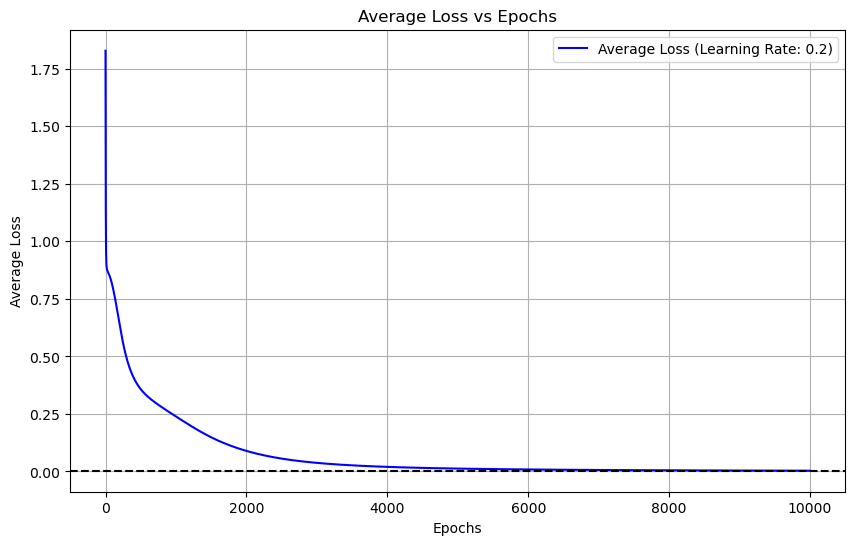

In [7]:
# plot the loss
plt.figure(figsize=(10, 6))
plt.plot(
    nn.loss_history,
    label=f"Average Loss (Learning Rate: {nn.learning_rate})",
    color="blue",
)
plt.title("Average Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.axhline(y=0, color="black", linestyle="--")
plt.legend()
plt.grid()
plt.show()

# Testing the trained network
The results are very close to the one expected.

In [8]:
for i in range(8):
    print(np.array_str(np.round(nn(X[i])[0], 1), precision=1, suppress_small=True))

[0.9 0.  0.  0.  0.  0.  0.  0. ]
[0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0.]
[0.  0.  0.  0.  0.9 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.9 0.  0. ]
[0. 0. 0. 0. 0. 0. 1. 0.]
[0.  0.  0.  0.  0.  0.  0.  0.9]


# Experimenting with different Learning Rates
Experimenting with different learning rates, we can see that the network converges faster with higher learning rates, using smaller values (0.001 and 0.002) we can also see that network converges to a higher loss value, indicating that a local minimum was found.
In this case using higher values for the learning doesn't show any significant drawback, converging faster to a loss value very close to zero.

Training with learning rate: 0.001...
Training with learning rate: 0.002...
Training with learning rate: 0.01...
Training with learning rate: 0.02...
Training with learning rate: 0.1...
Training with learning rate: 0.2...


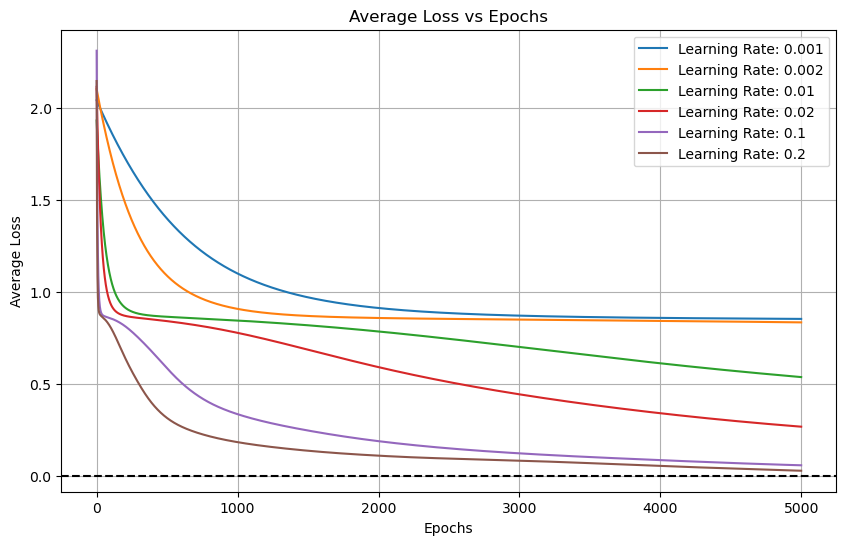

In [9]:
lrs = [0.001, 0.002, 0.01, 0.02, 0.1, 0.2]

losses = []
for lr in lrs:
    print(f"Training with learning rate: {lr}...")
    _nn = NN(layers = layers, lr = lr)
    _nn.train(X, 5000)
    losses.append(_nn.loss_history)

plt.figure(figsize=(10, 6))
for i, loss in enumerate(losses):
    plt.plot(loss, label=f"Learning Rate: {lrs[i]}")
plt.title("Average Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.axhline(y=0, color="black", linestyle="--")
plt.legend()
plt.grid()
plt.show()

# Taking a look at the model

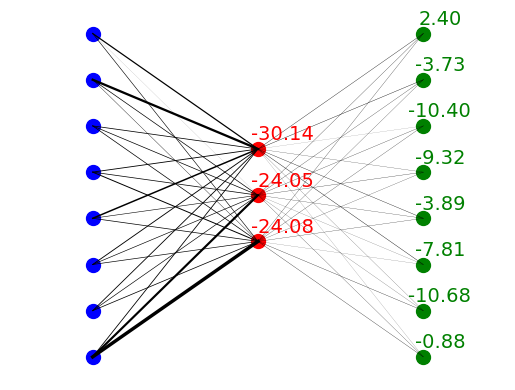

In [10]:
# Define the positions of the neurons in the input, hidden, and output layers
input_layer_pos = [(0, i) for i in range(8)]
hidden_layer_pos = [(1, i + 2.5) for i in range(HIDDENT_LAYER_SIZE)]
output_layer_pos = [(2, i) for i in range(8)]

fig, ax = plt.subplots()

# Plot the neurons
for pos in input_layer_pos:
    ax.plot(pos[0], pos[1], "bo", markersize=10)
for pos in hidden_layer_pos:
    ax.plot(pos[0], pos[1], "ro", markersize=10)
for pos in output_layer_pos:
    ax.plot(pos[0], pos[1], "go", markersize=10)

# Plot the weights as lines with varying thickness for the first layer
for i, input_pos in enumerate(input_layer_pos):
    for j, hidden_pos in enumerate(hidden_layer_pos):
        weight = nn.layers[0].weights[i, j]
        ax.plot(
            [input_pos[0], hidden_pos[0]],
            [input_pos[1], hidden_pos[1]],
            "k-",
            lw=abs(weight) / 50,
        )

# Plot the weights as lines with varying thickness for the second layer
for i, hidden_pos in enumerate(hidden_layer_pos):
    for j, output_pos in enumerate(output_layer_pos):
        weight = nn.layers[1].weights[i, j]
        ax.plot(
            [hidden_pos[0], output_pos[0]],
            [hidden_pos[1], output_pos[1]],
            "k-",
            lw=abs(weight) / 50,
        )

# Annotate the biases
for i, hidden_pos in enumerate(hidden_layer_pos):
    bias = nn.layers[0].biases[0, i]
    ax.text(
        hidden_pos[0] + 0.15,
        hidden_pos[1] + 0.2,
        f"{bias:.2f}",
        color="red",
        fontsize=14,
        ha="center",
    )
for i, output_pos in enumerate(output_layer_pos):
    bias = nn.layers[1].biases[0, i]
    ax.text(
        output_pos[0] + 0.1,
        output_pos[1] + 0.2,
        f"{bias:.2f}",
        color="green",
        fontsize=14,
        ha="center",
    )

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 7.5)
ax.axis("off")
plt.show()

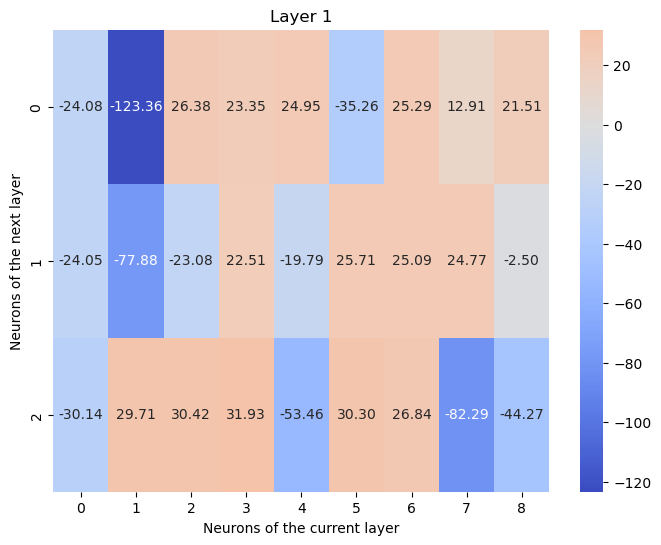

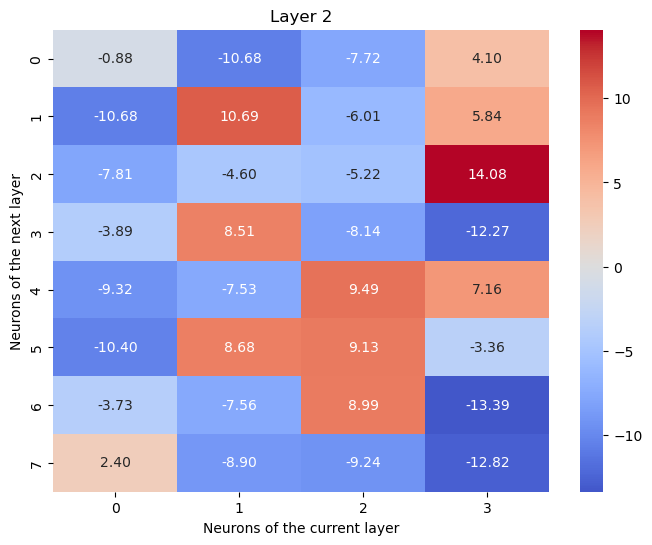

In [11]:
import seaborn as sns

for i in range(len(layers)):
    weights_with_biases = np.concatenate(
        [nn.layers[i].biases, nn.layers[i].weights], axis=0
    )
    plt.figure(figsize=(8, 6))
    sns.heatmap(weights_with_biases.T, cmap="coolwarm", annot=True, fmt=".2f", center=0)
    plt.title("Layer " + str(i + 1))
    plt.xlabel("Neurons of the current layer")
    plt.ylabel("Neurons of the next layer")
    plt.show()

**Layer 1**

The heatmap of Layer 1 has a weight matrix with significant variation in values, as indicated by the color scale. We can see that there are both large positive and large negative weights. For instance, the color scale shows values close to +67 for some weights (indicated in light orange), while others reach as low as −333.03 (dark blue).
The extreme negative values, especially around −305.72 and −333.03, could indicate connections that have a strong inhibitory effect in this layer.

These neurons are thus the ones that have highly influential connections compared to others.

**Layer 2**

Similar to Layer 1, Layer 2 shows a mix of positive and negative weights, though the range of values is less extreme. The highest positive value in this layer is 17.18, while the lowest is approximately −23.78, indicating more moderate weights relative to Layer 1.
The colors are more evenly distributed across this heatmap, suggesting a balanced set of connections without extreme outliers. This could imply a more stable influence of weights in this layer.

# Activation of the hidden layer
In the graph the activation of the hidden layer is shown for all 8 of the test examples, every row rapprents a different example and every column rappresent a different neuron of the hidden layer. We can see that for almost each case the activation are quite different.

If we apply a threshold of 0.1 we can see it more clearly, every case has a unique rappresentation in the hidden layer of the network, indicating some sort of mapping between the input and the hidden layer.

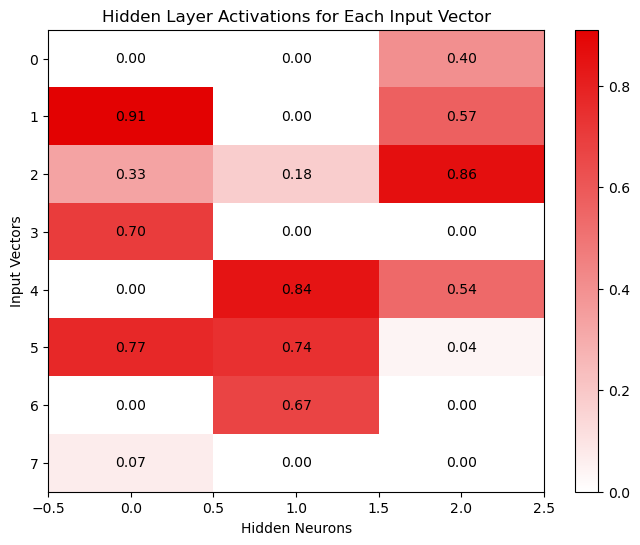

In [12]:
hidden_activations = []
for i in range(8):
    hidden_value = nn.layers[0].forward(X[i])
    hidden_activations.append(hidden_value)

hidden_activations = np.array(hidden_activations).reshape(8, HIDDENT_LAYER_SIZE).round(2)


cmap = LinearSegmentedColormap.from_list("white_red", ["white", "#e30202"])

plt.figure(figsize=(8, 6))
plt.imshow(hidden_activations, aspect="auto", cmap=cmap)

for i in range(hidden_activations.shape[0]):
    for j in range(hidden_activations.shape[1]):
        plt.text(
            j,
            i,
            f"{hidden_activations[i, j]:.2f}",
            ha="center",
            va="center",
            color="black",
        )

plt.colorbar()
plt.xlabel("Hidden Neurons")
plt.ylabel("Input Vectors")
plt.title("Hidden Layer Activations for Each Input Vector")
plt.show()

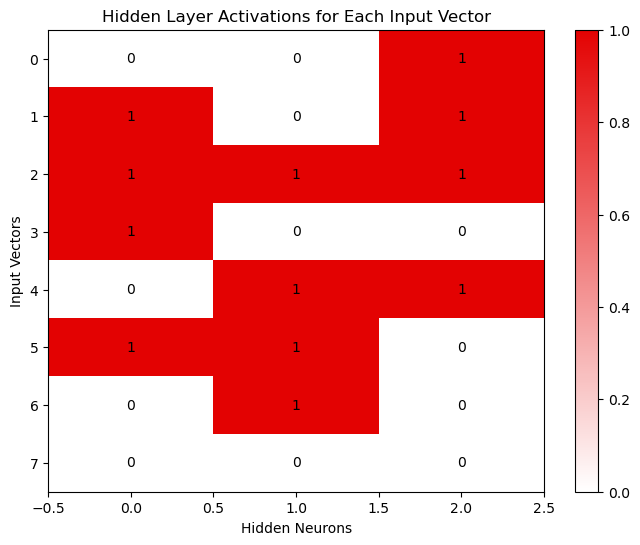

In [13]:
thresholded_activations = np.where(hidden_activations > 0.1, 1, 0)

plt.figure(figsize=(8, 6))
plt.imshow(thresholded_activations, aspect="auto", cmap=cmap)

for i in range(thresholded_activations.shape[0]):
    for j in range(thresholded_activations.shape[1]):
        plt.text(
            j,
            i,
            f"{thresholded_activations[i, j]:.0f}",
            ha="center",
            va="center",
            color="black",
        )

plt.colorbar()
plt.xlabel("Hidden Neurons")
plt.ylabel("Input Vectors")
plt.title("Hidden Layer Activations for Each Input Vector")
plt.show()